In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from dqn_conv_Atari import *
from gym.core import ObservationWrapper
from gym.spaces import Box
from gym.spaces.box import Box
from gym.core import Wrapper
from tqdm import tqdm

In [2]:
class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        super(PreprocessAtari, self).__init__(env)
        self.img_size = (84, 84)
        self.observation_space = Box(0.0, 1.0, [self.img_size[0], self.img_size[1], 1], dtype=np.float32)

    def observation(self, img):
        # Crop and resize image
        if isinstance(img, tuple):
            img = img[0]
        img = img[34:-16, :, :]  # crop top and bottom
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        img = cv2.resize(img, self.img_size)
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        return img

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4):
        super(FrameBuffer, self).__init__(env)
        self.observation_space = Box(low=0.0, high=1.0, shape=(env.observation_space.shape[0], env.observation_space.shape[1], env.observation_space.shape[2] * n_frames), dtype=np.float32)
        self.framebuffer = np.zeros(self.observation_space.shape, dtype=np.float32)
        self.n_frames = n_frames

    def reset(self):
        self.framebuffer = np.zeros_like(self.framebuffer)
        obs = self.env.reset()
        for _ in range(self.n_frames):
            self.update_buffer(obs)
        return self.framebuffer

    def step(self, action):
        new_obs, reward, done, info = self.env.step(action)
        self.update_buffer(new_obs)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        axis = 2  # For channel last format
        self.framebuffer = np.roll(self.framebuffer, shift=-img.shape[axis], axis=axis)
        self.framebuffer[..., -img.shape[axis]:] = img

C:\Users\10480\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\10480\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\10480\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gym\utils\passive_env_checker.py:190: UserWarning: WARN: Futu

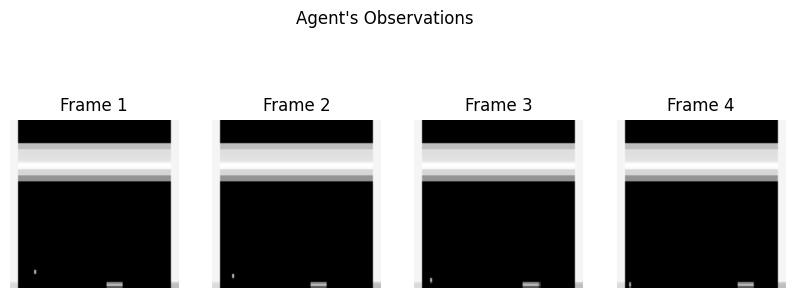

In [3]:


def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4)
    return env

#Instatntiate gym Atari-Breakout environment
env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=(10, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(obs[..., i], cmap='gray')
    plt.title(f"Frame {i + 1}")
    plt.axis('off')
plt.suptitle("Agent's Observations")
plt.show()

  0%|          | 1/500 [00:01<11:33,  1.39s/it]

Episode 0: Done; Average score 2.0; Epsilon: 0.9964999999999926


 10%|█         | 51/500 [01:16<10:20,  1.38s/it]

Episode 50: Done; Average score 1.0588235294117647; Epsilon: 0.7814499999995388


 20%|██        | 101/500 [02:39<12:11,  1.83s/it]

Episode 100: Done; Average score 1.11; Epsilon: 0.5530749999990568


 30%|███       | 151/500 [04:09<11:22,  1.96s/it]

Episode 150: Done; Average score 1.17; Epsilon: 0.32077499999896464


 40%|████      | 201/500 [05:48<09:06,  1.83s/it]

Episode 200: Done; Average score 1.3; Epsilon: 0.06252499999899308


 50%|█████     | 251/500 [07:35<09:00,  2.17s/it]

Episode 250: Done; Average score 1.42; Epsilon: 0.01


 60%|██████    | 301/500 [09:29<07:18,  2.20s/it]

Episode 300: Done; Average score 1.68; Epsilon: 0.01


 70%|███████   | 351/500 [11:37<05:39,  2.28s/it]

Episode 350: Done; Average score 2.07; Epsilon: 0.01


 80%|████████  | 401/500 [13:42<04:26,  2.69s/it]

Episode 400: Done; Average score 2.08; Epsilon: 0.01


 90%|█████████ | 451/500 [15:57<02:15,  2.77s/it]

Episode 450: Done; Average score 2.09; Epsilon: 0.01


100%|██████████| 500/500 [18:08<00:00,  2.18s/it]


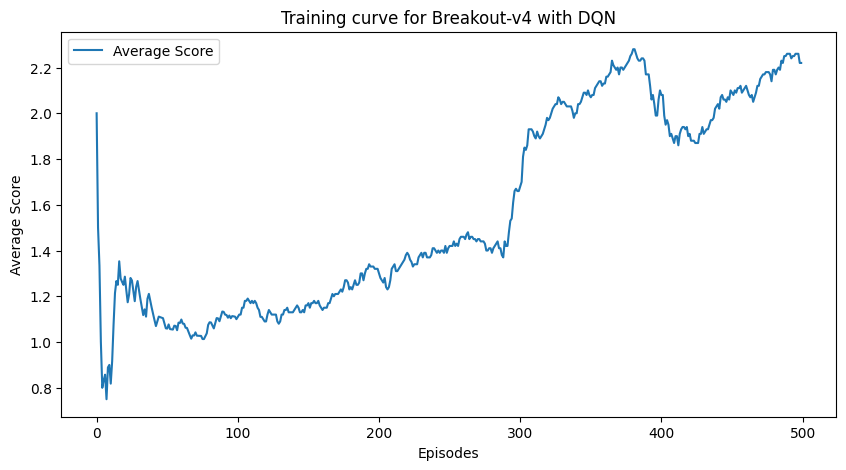

In [5]:
from dqn_conv_Atari import *
state = env.reset()
agent = AgentConv(gamma=0.99, epsilon=1, lr=0.00025, max_mem_size=int(1e5), input_dims=(84, 84, 4), batch_size=64, n_actions=env.action_space.n, eps_end=0.01, eps_dec=2.5e-5)
num_episodes = int(500)
scores = []
average_scores = [] 
#agent.reload_checkpoint('checkpoints/dqn_checkpoint_400.pth')
for i in tqdm(range(num_episodes)):
    done = False
    state = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(state)
        new_state, reward, done, info = env.step(action)
        agent.store_transition(state, action, reward, new_state, done)
        agent.learn()
        state = new_state
        score += reward
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    average_scores.append(avg_score)
    if i % 50 == 0:
        print(f'Episode {i}: Done; Average score {avg_score}; Epsilon: {agent.epsilon}')
        agent.save_checkpoint(iteration=i)
plt.figure(figsize=(10, 5))
plt.plot(average_scores, label='Average Score')
plt.title('Training curve for Breakout-v4 with DQN')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.legend()
plt.show()

  0%|          | 1/500 [00:02<20:19,  2.44s/it]

Episode 0: Done; Average score 2.24; Epsilon: 0.01


 10%|█         | 51/500 [02:13<22:36,  3.02s/it]

Episode 50: Done; Average score 2.06; Epsilon: 0.01


 20%|██        | 101/500 [04:27<17:29,  2.63s/it]

Episode 100: Done; Average score 1.96; Epsilon: 0.01


 30%|███       | 151/500 [06:32<16:03,  2.76s/it]

Episode 150: Done; Average score 2.09; Epsilon: 0.01


 40%|████      | 201/500 [08:51<13:29,  2.71s/it]

Episode 200: Done; Average score 2.19; Epsilon: 0.01


 50%|█████     | 251/500 [11:07<11:13,  2.70s/it]

Episode 250: Done; Average score 2.28; Epsilon: 0.01


 60%|██████    | 301/500 [13:26<09:53,  2.98s/it]

Episode 300: Done; Average score 2.42; Epsilon: 0.01


 70%|███████   | 351/500 [16:16<06:43,  2.71s/it]

Episode 350: Done; Average score 2.7; Epsilon: 0.01


 80%|████████  | 401/500 [18:51<07:03,  4.28s/it]

Episode 400: Done; Average score 2.75; Epsilon: 0.01


 90%|█████████ | 451/500 [21:50<02:25,  2.97s/it]

Episode 450: Done; Average score 2.88; Epsilon: 0.01


100%|██████████| 500/500 [24:16<00:00,  2.91s/it]


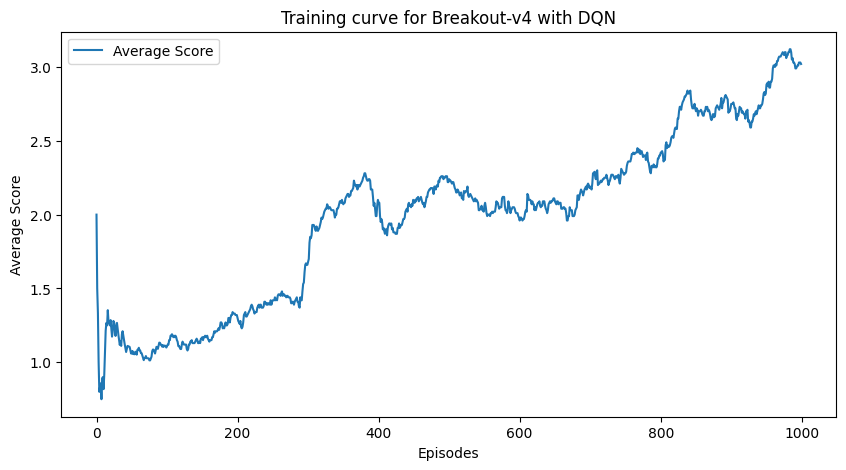

In [6]:
agent.reload_checkpoint('checkpoints/dqn_checkpoint_450.pth')
for i in tqdm(range(num_episodes)):
    done = False
    state = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(state)
        new_state, reward, done, info = env.step(action)
        agent.store_transition(state, action, reward, new_state, done)
        agent.learn()
        state = new_state
        score += reward
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    average_scores.append(avg_score)
    if i % 50 == 0:
        print(f'Episode {i}: Done; Average score {avg_score}; Epsilon: {agent.epsilon}')
        agent.save_checkpoint(iteration=i)
plt.figure(figsize=(10, 5))
plt.plot(average_scores, label='Average Score')
plt.title('Training curve for Breakout-v4 with DQN')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.legend()
plt.show()

  0%|          | 1/500 [00:02<18:16,  2.20s/it]

Episode 0: Done; Average score 2.96; Epsilon: 0.01


 10%|█         | 51/500 [02:47<26:47,  3.58s/it]

Episode 50: Done; Average score 3.38; Epsilon: 0.01


 20%|██        | 101/500 [05:14<20:33,  3.09s/it]

Episode 100: Done; Average score 3.41; Epsilon: 0.01


 30%|███       | 151/500 [07:44<18:28,  3.18s/it]

Episode 150: Done; Average score 2.93; Epsilon: 0.01


 40%|████      | 201/500 [10:12<19:47,  3.97s/it]

Episode 200: Done; Average score 2.81; Epsilon: 0.01


 50%|█████     | 251/500 [12:41<12:07,  2.92s/it]

Episode 250: Done; Average score 3.08; Epsilon: 0.01


 60%|██████    | 301/500 [15:26<10:05,  3.04s/it]

Episode 300: Done; Average score 3.87; Epsilon: 0.01


 70%|███████   | 351/500 [17:58<06:49,  2.75s/it]

Episode 350: Done; Average score 3.84; Epsilon: 0.01


 80%|████████  | 401/500 [20:41<05:29,  3.33s/it]

Episode 400: Done; Average score 3.8; Epsilon: 0.01


 90%|█████████ | 451/500 [23:11<02:16,  2.78s/it]

Episode 450: Done; Average score 3.76; Epsilon: 0.01


100%|██████████| 500/500 [25:41<00:00,  3.08s/it]


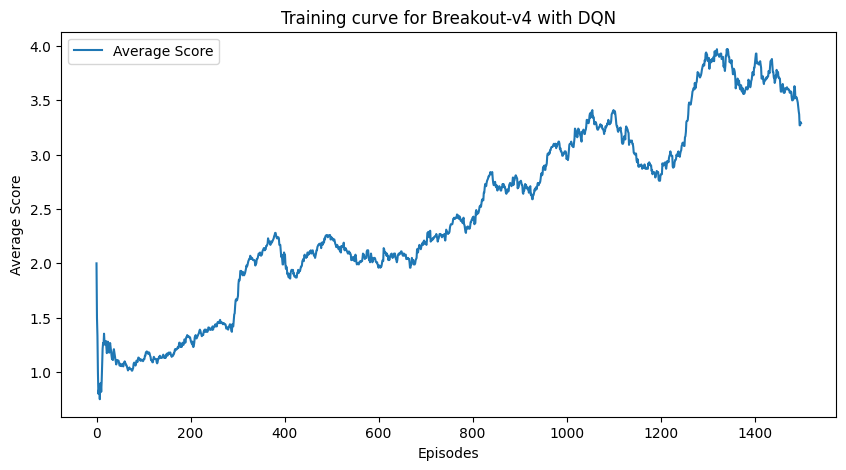

In [7]:
agent.reload_checkpoint('checkpoints/dqn_checkpoint_450.pth')
for i in tqdm(range(num_episodes)):
    done = False
    state = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(state)
        new_state, reward, done, info = env.step(action)
        agent.store_transition(state, action, reward, new_state, done)
        agent.learn()
        state = new_state
        score += reward
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    average_scores.append(avg_score)
    if i % 50 == 0:
        print(f'Episode {i}: Done; Average score {avg_score}; Epsilon: {agent.epsilon}')
        agent.save_checkpoint(iteration=i)
plt.figure(figsize=(10, 5))
plt.plot(average_scores, label='Average Score')
plt.title('Training curve for Breakout-v4 with DQN')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.legend()
plt.show()

  0%|          | 1/500 [00:03<28:17,  3.40s/it]

Episode 0: Done; Average score 3.31; Epsilon: 0.01


 10%|█         | 51/500 [02:35<23:09,  3.10s/it]

Episode 50: Done; Average score 3.47; Epsilon: 0.01


 20%|██        | 101/500 [05:03<22:11,  3.34s/it]

Episode 100: Done; Average score 3.55; Epsilon: 0.01


 30%|███       | 151/500 [07:30<15:38,  2.69s/it]

Episode 150: Done; Average score 3.35; Epsilon: 0.01


 40%|████      | 201/500 [09:59<16:32,  3.32s/it]

Episode 200: Done; Average score 3.55; Epsilon: 0.01


 50%|█████     | 251/500 [12:25<11:32,  2.78s/it]

Episode 250: Done; Average score 3.5; Epsilon: 0.01


 60%|██████    | 301/500 [14:52<08:49,  2.66s/it]

Episode 300: Done; Average score 3.78; Epsilon: 0.01


 70%|███████   | 351/500 [17:20<06:56,  2.79s/it]

Episode 350: Done; Average score 4.01; Epsilon: 0.01


 80%|████████  | 401/500 [19:53<04:51,  2.94s/it]

Episode 400: Done; Average score 3.82; Epsilon: 0.01


 90%|█████████ | 451/500 [22:18<02:20,  2.86s/it]

Episode 450: Done; Average score 4.05; Epsilon: 0.01


100%|██████████| 500/500 [24:39<00:00,  2.96s/it]


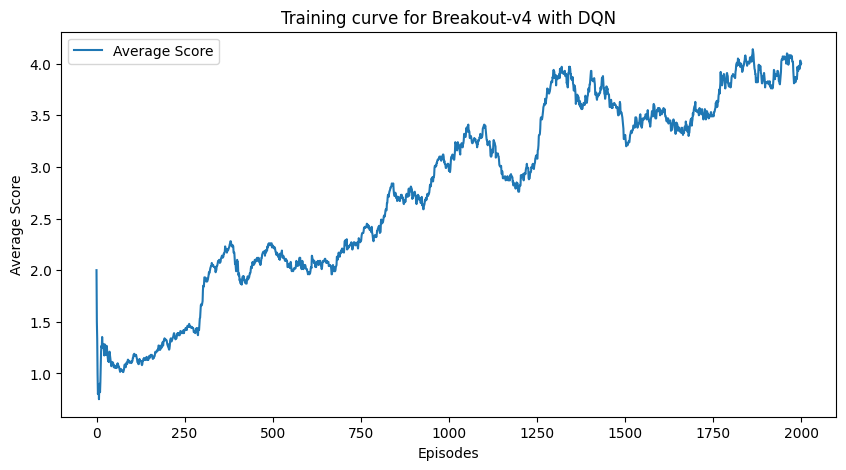

In [8]:
agent.reload_checkpoint('checkpoints/dqn_checkpoint_450.pth')
for i in tqdm(range(num_episodes)):
    done = False
    state = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(state)
        new_state, reward, done, info = env.step(action)
        agent.store_transition(state, action, reward, new_state, done)
        agent.learn()
        state = new_state
        score += reward
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    average_scores.append(avg_score)
    if i % 50 == 0:
        print(f'Episode {i}: Done; Average score {avg_score}; Epsilon: {agent.epsilon}')
        agent.save_checkpoint(iteration=i)
plt.figure(figsize=(10, 5))
plt.plot(average_scores, label='Average Score')
plt.title('Training curve for Breakout-v4 with DQN')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.legend()
plt.show()

  0%|          | 1/500 [00:03<31:35,  3.80s/it]

Episode 0: Done; Average score 4.04; Epsilon: 0.01


 10%|█         | 51/500 [02:33<19:45,  2.64s/it]

Episode 50: Done; Average score 4.01; Epsilon: 0.01


 20%|██        | 101/500 [04:59<23:07,  3.48s/it]

Episode 100: Done; Average score 3.85; Epsilon: 0.01


 30%|███       | 151/500 [07:39<20:04,  3.45s/it]

Episode 150: Done; Average score 3.77; Epsilon: 0.01


 40%|████      | 201/500 [10:09<14:11,  2.85s/it]

Episode 200: Done; Average score 3.94; Epsilon: 0.01


 50%|█████     | 251/500 [12:35<13:00,  3.13s/it]

Episode 250: Done; Average score 3.83; Epsilon: 0.01


 60%|██████    | 301/500 [14:56<08:46,  2.65s/it]

Episode 300: Done; Average score 3.5; Epsilon: 0.01


 70%|███████   | 351/500 [17:42<10:17,  4.14s/it]

Episode 350: Done; Average score 3.55; Epsilon: 0.01


 80%|████████  | 401/500 [20:05<04:17,  2.60s/it]

Episode 400: Done; Average score 3.74; Epsilon: 0.01


 90%|█████████ | 451/500 [22:20<02:31,  3.09s/it]

Episode 450: Done; Average score 3.64; Epsilon: 0.01


100%|██████████| 500/500 [24:44<00:00,  2.97s/it]


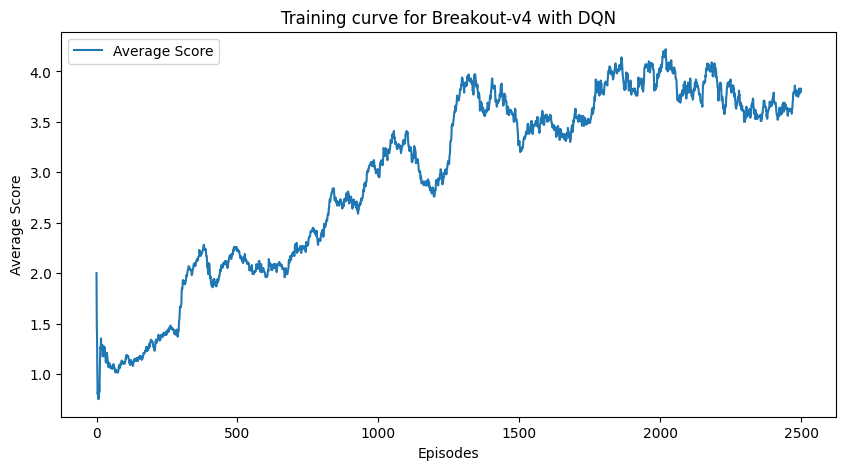

In [9]:
agent.reload_checkpoint('checkpoints/dqn_checkpoint_450.pth')
for i in tqdm(range(num_episodes)):
    done = False
    state = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(state)
        new_state, reward, done, info = env.step(action)
        agent.store_transition(state, action, reward, new_state, done)
        agent.learn()
        state = new_state
        score += reward
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    average_scores.append(avg_score)
    if i % 50 == 0:
        print(f'Episode {i}: Done; Average score {avg_score}; Epsilon: {agent.epsilon}')
        agent.save_checkpoint(iteration=i)
plt.figure(figsize=(10, 5))
plt.plot(average_scores, label='Average Score')
plt.title('Training curve for Breakout-v4 with DQN')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.legend()
plt.show()

In [10]:
env.close()

23m26s

  0%|          | 1/500 [00:03<30:25,  3.66s/it]

Episode 0: Done; Average score 8.54; Epsilon: 0.05


 10%|█         | 51/500 [01:36<10:18,  1.38s/it]

Episode 50: Done; Average score 6.72; Epsilon: 0.05


 20%|██        | 101/500 [04:06<13:59,  2.10s/it]

Episode 100: Done; Average score 5.41; Epsilon: 0.05


 30%|███       | 151/500 [05:44<11:04,  1.90s/it]

Episode 150: Done; Average score 6.09; Epsilon: 0.05


 40%|████      | 201/500 [07:51<15:48,  3.17s/it]

Episode 200: Done; Average score 5.98; Epsilon: 0.05


 50%|█████     | 251/500 [10:40<11:58,  2.88s/it]

Episode 250: Done; Average score 8.32; Epsilon: 0.05


 60%|██████    | 301/500 [13:13<08:59,  2.71s/it]

Episode 300: Done; Average score 9.24; Epsilon: 0.05


 70%|███████   | 351/500 [15:58<08:07,  3.27s/it]

Episode 350: Done; Average score 9.25; Epsilon: 0.05


 80%|████████  | 401/500 [18:16<04:29,  2.72s/it]

Episode 400: Done; Average score 8.56; Epsilon: 0.05


 90%|█████████ | 451/500 [20:02<01:29,  1.82s/it]

Episode 450: Done; Average score 6.33; Epsilon: 0.05


100%|██████████| 500/500 [21:28<00:00,  2.58s/it]


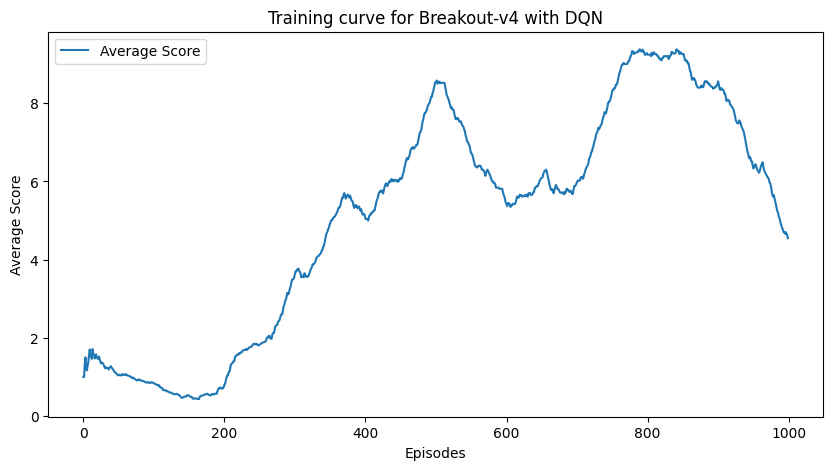

In [11]:
agent.reload_checkpoint('checkpoints/dqn_checkpoint_500.pth')
for i in tqdm(range(num_episodes)):
    done = False
    state = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(state)
        new_state, reward, done, info = env.step(action)
        agent.store_transition(state, action, reward, new_state, done)
        agent.learn()
        state = new_state
        score += reward
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    average_scores.append(avg_score)
    if i % 50 == 0:
        print(f'Episode {i}: Done; Average score {avg_score}; Epsilon: {agent.epsilon}')
        agent.save_checkpoint(iteration=i)
plt.figure(figsize=(10, 5))
plt.plot(average_scores, label='Average Score')
plt.title('Training curve for Breakout-v4 with DQN')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.legend()
plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:05<42:57,  5.16s/it]

Episode 0: Done; Average score 4.55; Epsilon: 0.05


 10%|█         | 51/500 [01:49<11:03,  1.48s/it]

Episode 50: Done; Average score 4.17; Epsilon: 0.05


 20%|██        | 101/500 [03:02<08:23,  1.26s/it]

Episode 100: Done; Average score 2.99; Epsilon: 0.05


 30%|███       | 151/500 [04:08<07:40,  1.32s/it]

Episode 150: Done; Average score 1.48; Epsilon: 0.05


 40%|████      | 201/500 [05:09<06:09,  1.23s/it]

Episode 200: Done; Average score 1.14; Epsilon: 0.05


 50%|█████     | 251/500 [06:21<05:36,  1.35s/it]

Episode 250: Done; Average score 1.45; Epsilon: 0.05


 60%|██████    | 301/500 [07:19<04:00,  1.21s/it]

Episode 300: Done; Average score 1.32; Epsilon: 0.05


 70%|███████   | 351/500 [08:23<03:15,  1.31s/it]

Episode 350: Done; Average score 0.83; Epsilon: 0.05


 80%|████████  | 401/500 [09:28<02:05,  1.27s/it]

Episode 400: Done; Average score 1.06; Epsilon: 0.05


 90%|█████████ | 451/500 [10:29<00:57,  1.17s/it]

Episode 450: Done; Average score 1.12; Epsilon: 0.05


100%|██████████| 500/500 [11:28<00:00,  1.38s/it]


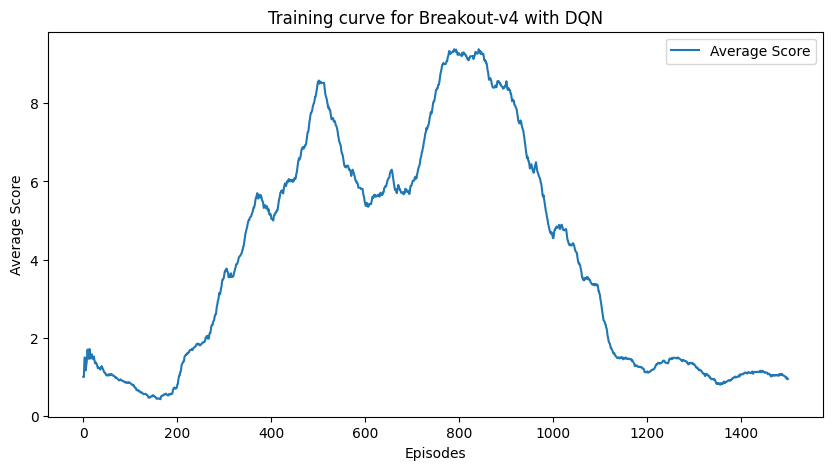

In [12]:
agent.reload_checkpoint('checkpoints/dqn_checkpoint_500.pth')
for i in tqdm(range(num_episodes)):
    done = False
    state = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(state)
        new_state, reward, done, info = env.step(action)
        agent.store_transition(state, action, reward, new_state, done)
        agent.learn()
        state = new_state
        score += reward
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    average_scores.append(avg_score)
    if i % 50 == 0:
        print(f'Episode {i}: Done; Average score {avg_score}; Epsilon: {agent.epsilon}')
        agent.save_checkpoint(iteration=i)
plt.figure(figsize=(10, 5))
plt.plot(average_scores, label='Average Score')
plt.title('Training curve for Breakout-v4 with DQN')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.legend()
plt.show()

In [4]:
from dqn_conv_Atari import *
state = env.reset()
agent = AgentConv(gamma=0.99, epsilon=1, lr=0.00025, max_mem_size=int(1e5), input_dims=(84, 84, 4), batch_size=64, n_actions=env.action_space.n, eps_end=0.05, eps_dec=4.5e-5)
num_episodes = int(500)
scores = []
average_scores = [] 
agent.reload_checkpoint('checkpoints/dqn_checkpoint_500.pth')
for i in tqdm(range(num_episodes)):
    done = False
    state = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(state)
        new_state, reward, done, info = env.step(action)
        agent.store_transition(state, action, reward, new_state, done)
        agent.learn()
        state = new_state
        score += reward
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    average_scores.append(avg_score)
    if i % 50 == 0:
        print(f'Episode {i}: Done; Average score {avg_score}; Epsilon: {agent.epsilon}')
        agent.save_checkpoint(iteration=i)
plt.figure(figsize=(10, 5))
plt.plot(average_scores, label='Average Score')
plt.title('Training curve for Breakout-v4 with DQN')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.legend()
plt.show()

  0%|          | 1/500 [00:02<19:39,  2.36s/it]

Episode 0: Done; Average score 2.0; Epsilon: 0.05


 10%|█         | 51/500 [00:50<07:26,  1.01it/s]

Episode 50: Done; Average score 0.5686274509803921; Epsilon: 0.05


 20%|██        | 101/500 [01:39<05:57,  1.11it/s]

Episode 100: Done; Average score 0.59; Epsilon: 0.05


 30%|███       | 151/500 [02:28<06:12,  1.07s/it]

Episode 150: Done; Average score 0.62; Epsilon: 0.05


 40%|████      | 201/500 [03:21<05:27,  1.10s/it]

Episode 200: Done; Average score 0.64; Epsilon: 0.05


 50%|█████     | 251/500 [04:11<04:07,  1.01it/s]

Episode 250: Done; Average score 0.59; Epsilon: 0.05


 60%|██████    | 301/500 [05:04<04:11,  1.26s/it]

Episode 300: Done; Average score 0.65; Epsilon: 0.05


 70%|███████   | 351/500 [05:58<02:42,  1.09s/it]

Episode 350: Done; Average score 0.77; Epsilon: 0.05


 80%|████████  | 401/500 [06:52<01:44,  1.06s/it]

Episode 400: Done; Average score 0.71; Epsilon: 0.05


 86%|████████▌ | 429/500 [07:26<01:13,  1.04s/it]


KeyboardInterrupt: 